In [19]:
import numpy as np
import torch
import sys
from utils_old import *
import utils
from matplotlib import pyplot as plt
import torch.nn as nn
import time
from numba import cuda
from tqdm import tqdm, trange
import os
import pyroc
import pandas as pd
import gc
from IPython.display import clear_output
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"  
device = torch.device("cuda:0")
dtype = torch.float32
torch.manual_seed(42)
np.random.seed(42)

In [20]:

H = 500
out= 100
L = 1
class DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, out, bias=True),
        )
    def forward(self, input):
        output = self.model(input)
        return output

class another_DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(another_DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, 28, bias=True),
        )
    def forward(self, input):
        output = self.model(input) + input
        return output

class Classifier(torch.nn.Module):
    def __init__(self, H=300, layers = 5):
        super(Classifier, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, 1, bias=True),
            torch.nn.Sigmoid(),
        )
        if layers == 6:
            self.model = torch.nn.Sequential(
                torch.nn.Linear(28, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, 1, bias=True),
                torch.nn.Sigmoid(),
            )
    def forward(self, input):
        output = self.model(input)
        return output

In [21]:
dataset = np.load('HIGGS.npy')
dataset_P = dataset[dataset[:,0]==0][:, 1:] # background (5829122, 28)
dataset_Q = dataset[dataset[:,0]==1][:, 1:] # signal     (5170877, 28)
del dataset

In [22]:
# 看(n_eval,m)
# 选定 X_eval, Y_eval, 还要算phi=Eq[k(y,z)]-Ep[k(x,z)]的threhold在哪里
# 必须手算!
def generate_PQ(n_eval, Samples, batch_size = 5000, If_n_large_MonteCarlo = 1000):
    X_eval = dataset_P[np.random.choice(dataset_P.shape[0], n_eval, replace=False)]
    Y_eval = dataset_Q[np.random.choice(dataset_Q.shape[0], n_eval, replace=False)]
    EKxx, EKyy, EKxy = compute_gamma(X_eval, Y_eval, model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst, MonteCarlo=If_n_large_MonteCarlo)
    # 算定下来X_eval, Y_eval之后phi的真实的分布
    batches = (Samples-1)//batch_size + 1
    P_scores = np.zeros(Samples)
    Q_scores = np.zeros(Samples)
    for i in trange(batches):
        remain = batch_size
        if i==batches-1:
            remain = Samples - batch_size*(batches-1)
        S_hand = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], remain, replace=False)],
                    dataset_Q[np.random.choice(dataset_Q.shape[0], remain, replace=False)]), axis=0)
        S_hand = MatConvert(S_hand, device, dtype)
        PQhat_hand = compute_score_func(S_hand, X_eval, Y_eval, 
                    model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                    M = n_eval)
        PQhat_hand = PQhat_hand.cpu().detach().numpy()
        P_scores[i*batch_size: i*batch_size+remain] = PQhat_hand[:remain]
        Q_scores[i*batch_size: i*batch_size+remain] = PQhat_hand[remain:]
    return X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy


In [23]:
# 注意P_scores, Q_scores已经考虑到n_eval贡献的方差
# EKxx, EKyy, EKxy完全是n_eval决定
class PQ_data():
    def __init__(self, P_scores, Q_scores, EKxx, EKyy, EKxy):
        self.P_scores = P_scores
        self.Q_scores = Q_scores
        self.P_mean = np.mean(P_scores)
        self.P_std = np.std(P_scores)
        self.Q_mean = np.mean(Q_scores)
        self.Q_std = np.std(Q_scores)
        self.EKxx = EKxx
        self.EKyy = EKyy
        self.EKxy = EKxy
    def pval_T_m_in_sigma(self, pi, m, use_gaussian, MonteCarlo):
        T = pi*self.Q_mean + (1-pi)*self.P_mean
        # use_gaussian: 是否用高斯近似, 0是用MonteCarlo近似，1是用高斯近似
        P_scores = self.P_scores
        mean = self.P_mean
        std = self.P_std
        if m==1:
            p = np.mean(P_scores > T)
            p = -scipy.stats.norm.ppf(p)
        if use_gaussian:
            p = (T-mean)/std*np.sqrt(m)
        else:
            T_mix_MonteCarlo_list = np.zeros(MonteCarlo)
            for i in range(MonteCarlo):
                idx = np.random.choice(P_scores.shape[0], m, replace=False)
                T_mix_MonteCarlo_list[i] = np.mean(P_scores[idx])
            p = np.mean(T_mix_MonteCarlo_list > T)
            p = -scipy.stats.norm.ppf(p)
        self.p = p
        return p
    def type_1_error_H0(self, pi, m, use_gaussian, MonteCarlo):
        P_scores = self.P_scores
        Q_scores = self.Q_scores
        mean = self.P_mean
        std = self.P_std
        P_mean = self.P_mean
        P_std = self.P_std
        Q_mean = self.Q_mean
        gamma = self.EKxx*(pi/2-1) + self.EKxy*(1-pi) + self.EKyy*(pi/2)
        #gamma = (pi/2)*Q_mean + (1-pi/2)*P_mean
        self.gamma = gamma
        if m==1:
            type_1_error = np.mean(P_scores > gamma)
        if use_gaussian:
            type_1_error = 1-scipy.stats.norm.cdf((gamma-mean)/std*np.sqrt(m))
        else:
            MonteCarlo_list = np.zeros(MonteCarlo)
            for i in range(MonteCarlo):
                idx = np.random.choice(P_scores.shape[0], m, replace=False)
                MonteCarlo_list[i] = np.mean(P_scores[idx])
            type_1_error = np.mean(MonteCarlo_list > gamma)
        self.type_1_error = type_1_error
        return type_1_error
    def type_2_error_H1(self, pi, m, use_gaussian, MonteCarlo):
        P_scores = self.P_scores
        Q_scores = self.Q_scores
        P_mean = self.P_mean
        P_std = self.P_std
        Q_mean = self.Q_mean
        Q_std = self.Q_std
        gamma = self.EKxx*(pi/2-1) + self.EKxy*(1-pi) + self.EKyy*(pi/2)
        #gamma = (pi/2)*Q_mean + (1-pi/2)*P_mean
        self.gamma = gamma
        if m==1:
            type_2_error = np.mean(Q_scores < gamma)
        if use_gaussian:
            mean = Q_mean*pi + P_mean*(1-pi)
            std = np.sqrt(pi*Q_std**2 + (1-pi)*P_std**2 + pi*(1-pi)*(P_mean-Q_mean)**2)
            type_2_error = scipy.stats.norm.cdf((gamma-mean)/std*np.sqrt(m))
        else:
            MonteCarlo_list = np.zeros(MonteCarlo)
            for i in range(MonteCarlo):
                Signals_idx = np.random.choice(Q_scores.shape[0], int(m*pi), replace=False)
                Backgrounds_idx = np.random.choice(P_scores.shape[0], int(m*(1-pi)), replace=False)
                MonteCarlo_list[i] = np.mean(np.concatenate((Q_scores[Signals_idx], P_scores[Backgrounds_idx])))
            type_2_error = np.mean(MonteCarlo_list < gamma)
        self.type_2_error = type_2_error
        return type_2_error

In [24]:
torch.cuda.empty_cache()
gc.collect()

1822

# 固定pi=0.1, Gaussian
所以对每一组(n,m,pi)有三个(p-val, typeI, typeII)  
pval = pval(平均H1) = 平均H1后面的尾  
type-I = gamma后面  

In [25]:
pi= 0.1

n_list = 10**np.linspace(1, 4, 30)
n_list = n_list.astype(int)
m_list = 10**np.linspace(1, 4, 30)
m_list = m_list.astype(int)

repeat_sample_n_eval = 10
Pval_mat = np.zeros((len(n_list), len(m_list), repeat_sample_n_eval))
Type1_mat = np.zeros((len(n_list), len(m_list), repeat_sample_n_eval))
Type2_mat = np.zeros((len(n_list), len(m_list), repeat_sample_n_eval))
Use_Gaussian = 1

In [26]:
# Pval_mat = np.load('Pval_mat.npy')
#Pval_mat = np.mean(Pval_mat[:,:,0:2], axis=2)
Type1_mat = np.mean(Type1_mat[:,:,0:2], axis=2)
Type2_mat = np.mean(Type2_mat[:,:,0:2], axis=2)


In [27]:
Pval_mat = np.load('Pval_mat.npy')
n_list_P_mat = 10**np.linspace(0.5, 4.3, 50)
m_list_P_mat = 10**np.linspace(0, 4.3, 50)
fig = plt.figure(figsize=(10,4))



plt.subplot(1,2,1)
plt.contourf(np.log10(n_list_P_mat), np.log10(m_list_P_mat), Pval_mat.T, levels=20)
plt.colorbar()
plt.xlabel('$lg(n_{eval})$')
plt.ylabel('lg(m)')
plt.title('Significance')
plt.ylim(1, 4)

# n_list = 10**np.linspace(0.5, 4.3, 40)
# n_list = n_list.astype(int)
# m_list = 10**np.linspace(0.5, 4.3, 40)
# m_list = m_list.astype(int)
# Type12_mat = np.load('type12.npy')
# plt.subplot(1,4,2)
# plt.contourf(np.log10(n_list), np.log10(m_list), Type12_mat.T, levels=20)
# plt.colorbar()
# plt.xlabel('$lg(n_{eval})$')
# plt.ylabel('lg(m)')
# plt.title('Type I error + II error')

ns = np.array([1300000, 1000000, 700000, 400000, 200000, 100000, 50000, 30000, 10000, 6000, 3000])
ms = 10**np.linspace(1, 4, 30)
ms = ms.astype(int)
P_m_ntr = np.load('P_m_ntr.npy')
Error_m_ntr = np.load('Error_m_ntr.npy')
plt.subplot(1,2,2)
im = plt.contourf(np.log10(ns), np.log10(ms), P_m_ntr.T, levels=20)
plt.colorbar()
plt.xlabel('$lg(n_{train})$')
plt.ylabel('lg(m)')
plt.title('Significance')


# plt.subplot(1,4,4)
# plt.contourf(np.log10(ns), np.log10(ms), Error_m_ntr.T, levels=20)
# plt.colorbar()
# plt.xlabel('$lg(n_{train})$')
# plt.ylabel('lg(m)')
# plt.title('Type I error + Type II error')

#plt.suptitle(r'Fix kernel ($n_{train}=1.3e6$), Use Gaussian Approx='+str(Use_Gaussian)+', $\pi$='+str(pi))
#fig.colorbar(im)
plt.savefig('./paper/tradeoff_p.pdf')

FileNotFoundError: [Errno 2] No such file or directory: 'Pval_mat.npy'

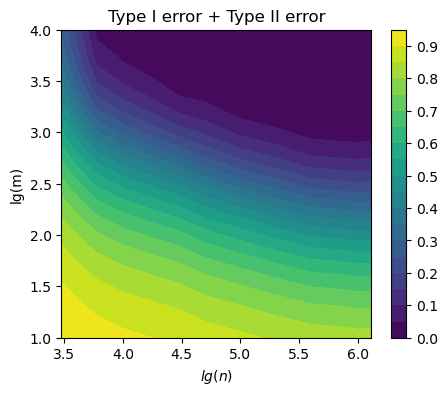

In [ ]:
fig = plt.figure(figsize=(5,4))
plt.contourf(np.log10(ns), np.log10(ms), Error_m_ntr.T, levels=20)
plt.colorbar()
plt.xlabel('$lg(n)$')
plt.ylabel('lg(m)')
plt.title('Type I error + Type II error')

#plt.suptitle(r'Fix kernel ($n_{train}=1.3e6$), Use Gaussian Approx='+str(Use_Gaussian)+', $\pi$='+str(pi))
fig.colorbar(im)
plt.savefig('./paper/tradeoff_type.pdf')

[1.41601572e-16 6.02303597e-12 1.13950872e-08 2.38005366e-06
 1.04454774e-04 1.51920741e-03 1.01096864e-02 3.86778616e-02
 1.00000000e-01 1.95908922e-01 3.15364473e-01 4.41760225e-01
 5.60804328e-01 6.64006085e-01 7.48354645e-01 8.14469651e-01
 8.64777269e-01 9.02259868e-01 9.29773627e-01 9.49757624e-01
 9.64164347e-01]


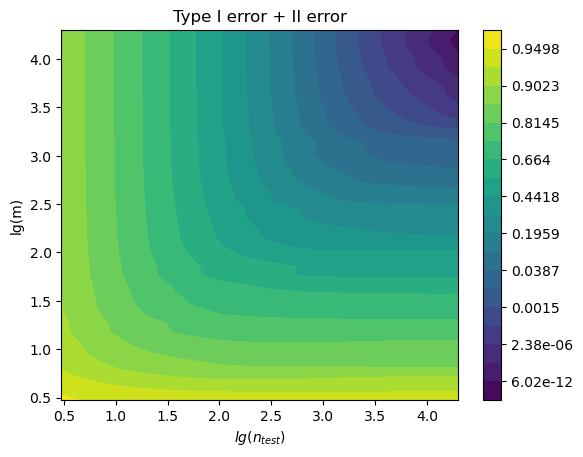

In [ ]:
Pval_mat = np.load('Pval_mat.npy')
n_list_P_mat = 10**np.linspace(0.5, 4.3, 50)
m_list_P_mat = 10**np.linspace(0, 4.3, 50)
# fig = plt.figure(figsize=(10,4))

n_list = 10**np.linspace(0.5, 4.3, 40)
n_list = n_list.astype(int)
m_list = 10**np.linspace(0.5, 4.3, 40)
m_list = m_list.astype(int)
Type12_mat_old = np.load('type12.npy')
Type12_mat_medi = np.load('Type1_mat_new_new.npy') + np.load('Type2_mat_new_new.npy')
Type12_mat_medi = np.mean(Type12_mat_medi[:,:,0:36], axis=2)
Type12_mat_new = np.load('Type1_mat_new_new_new_new.npy') + np.load('Type2_mat_new_new_new_new.npy')
Type12_mat_new = np.mean(Type12_mat_new[:,:,0:36], axis=2)
Type12_mat_new240 = np.load('Type1_mat_new240.npy') + np.load('Type2_mat_new240.npy')
Type12_mat_new240 = np.mean(Type12_mat_new240[:,:,0:242], axis=2)
Type12_mat_new210 = np.load('Type1_mat_new210.npy') + np.load('Type2_mat_new210.npy')
Type12_mat_new210 = np.mean(Type12_mat_new210[:,:,0:200], axis=2)
Type12_mat = ( Type12_mat_new240 + Type12_mat_new210)/2

levels = 20
fig, ax = plt.subplots()
Type12_mat_log = -np.log10(-np.log10(Type12_mat))
contourf_ = ax.contourf(np.log10(n_list), np.log10(m_list), Type12_mat_log,levels=levels)
cb = fig.colorbar(contourf_)

log_log_p_list = cb.mappable.levels # np.linspace(Type12_mat_log.min()+0.00001, Type12_mat_log.max()-0.000001, levels+1)
real_p_list = 10**(-(10**(-log_log_p_list)))
# cb.set_ticks(log_log_p_list)
# # numpy to str list with 3 decimal
print(real_p_list)
real_p_list = np.around(real_p_list, decimals=4)
real_p_list = real_p_list.astype(str)
real_p_list[0] = '1.42e-16'
real_p_list[1] = '6.02e-12'
real_p_list[2] = '1.14e-08'
real_p_list[3] = '2.38e-06'
cb.set_ticks(log_log_p_list[1:-1:2])
cb.set_ticklabels(real_p_list[1:-1:2])

plt.xlabel('$lg(n_{test})$')
plt.ylabel('lg(m)')
plt.title('Type I error + II error')
# plt.xlim(1, 4)
# plt.ylim(1, 4)
plt.savefig('./paper/tradeoff_type1.pdf')

array([-1.2 , -1.05, -0.9 , -0.75, -0.6 , -0.45, -0.3 , -0.15,  0.  ,
        0.15,  0.3 ,  0.45,  0.6 ,  0.75,  0.9 ,  1.05,  1.2 ,  1.35,
        1.5 ,  1.65,  1.8 ])